In [1]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate
import pandas as pd

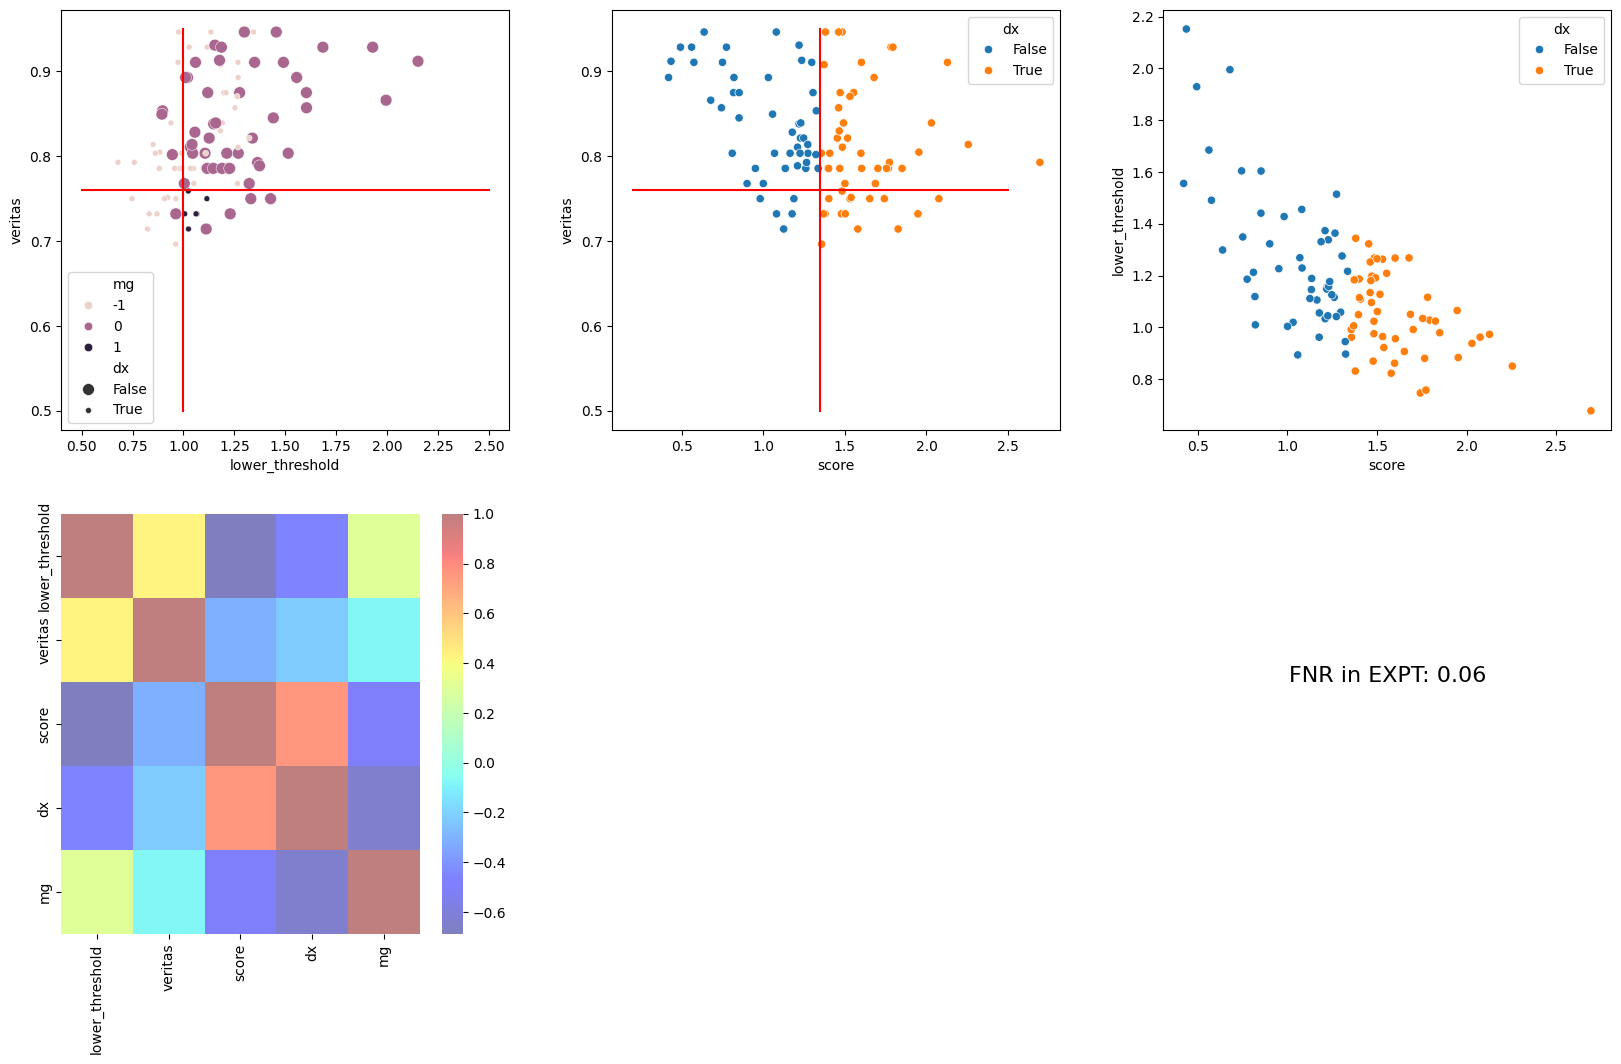

In [2]:
resf=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
d1,wf1=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid.png',
         validation_type='fnrexpt')

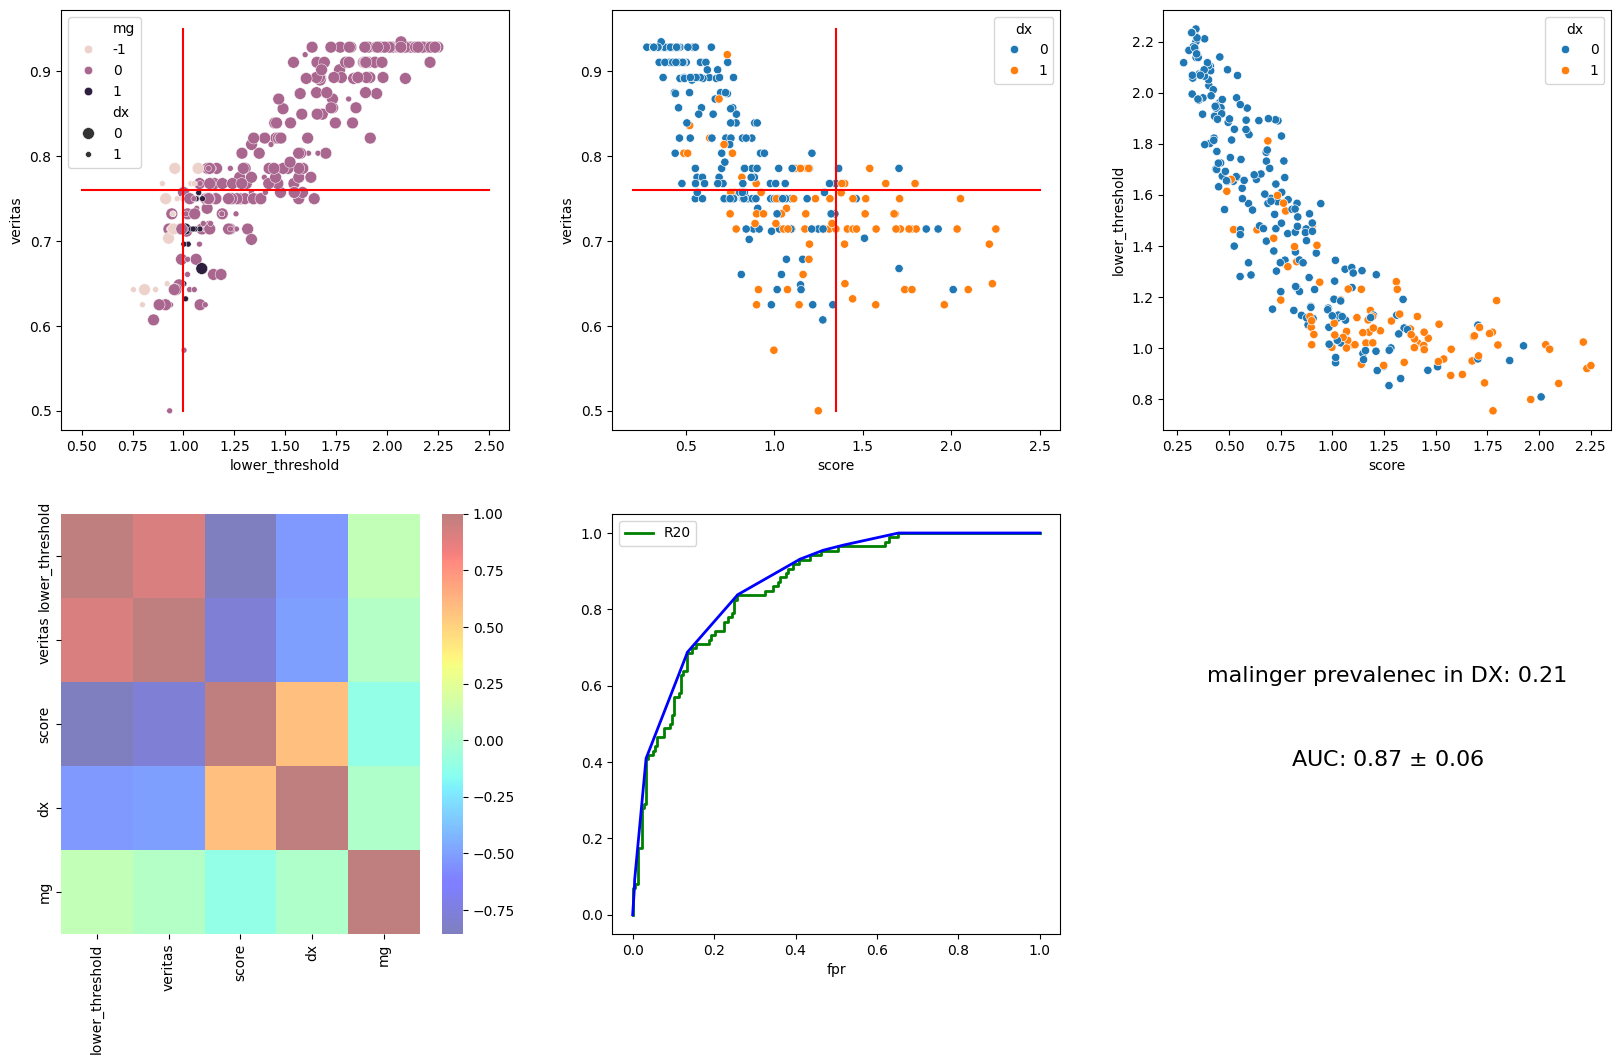

In [3]:
resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]
d2,wf2,zt=validate(resf,C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',
         validation_type='withdx')

In [4]:
from truthnet import load_veritas_model

In [5]:
M=load_veritas_model('../../veritas_models/veritas_002.pkl.gz')

In [6]:
M

{'version': '0.0.1',
 'model': qnet.Qnet,
 'model_neg': qnet.Qnet,
 'problem': '',
 'calibration_lower': array([1.20398725, 1.20398725, 1.20398725, ..., 1.29696621, 1.29880653,
        1.29880653]),
 'calibration_veritas': array([0.65791448, 0.65791448, 0.65791448, ..., 0.69963702, 0.68822158,
        0.68822158]),
 'dist_lower': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fcdfe1e2f40>,
 'LOWER_THRESHOLD': 1.1457407246215392,
 'dist_veritas': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fcdfe1ea160>,
 'VERITAS_THRESHOLD': 0.6971038897415065,
 'upper_scoretoprobability': <bound method processRoc.scoretoprobability of <zedstat.zedstat.processRoc object at 0x7fcdfe1e7e20>>,
 'UPPER_THRESHOLD': 1.2683587177075477,
 'AUC': (0.844551724137931, 0.8521131405190563, 0.8369903077568057)}

In [7]:
lf=M['calibration_lower']
xmin,xmax=1,1.4
ld=M['dist_lower']

In [8]:
vf=M['calibration_veritas']
vd=M['dist_veritas']
xmind,xmaxd=vf.min(),vf.max()

In [9]:
wf2.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
wf2

,$\kappa$,$\nu$,$\mu$,DX,$\chi$
CAT10050,1.766693,0.901883,0.680022,0,0
CAT10010,0.928472,0.714286,1.248364,0,0
CAT10020,1.117376,0.785714,1.025116,0,0
CAT10030,1.308874,0.767857,1.061628,0,0
CAT10040,1.775565,0.892857,0.684865,0,0
...,...,...,...,...,...
CAT12990,1.286232,0.767857,0.606269,0,0
CAT13011,1.133075,0.720779,1.325811,1,0
CAT13020,1.523528,0.793067,0.720745,0,0
CAT13040,1.895962,0.910714,0.444272,0,0


In [10]:
resf1=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf1.columns=['lower_threshold','veritas','score']

resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]

import numpy as np
from tqdm import tqdm
R={}
for c0 in tqdm(np.arange(.8,1.1,.05)):
    for c2 in np.arange(1,1.5,.05):
        b,_,_=validate(resf,C0=c0,C1=0.76,C2=c2,DX=True,
                   score=True,plots=False,verbose=False,
                   validation_type='withdx')
    
        a,_=validate(resf1,C0=c0,C1=0.76,C2=1.35,DX=False,score=True,plots=False,
                   validation_type='fnrexpt')

        R[(c0,c2)]=(1-a['fnr'],1-b['mratio'],1 - 0.5*(a['fnr'] + b['mratio']+a['fnr']*b['mratio'] ))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:59<00:00, 25.59s/it]


In [11]:
rf=pd.DataFrame(R).T
rf.columns=['sensitivity','maxspecificity','minauc']
#print(rf)

rf.index.name='thresholds'
rff=rf[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
#print(rff)
rff.to_csv('perf.csv')

from zedstat import zedstat
ztm=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+310,
                      positive_samples=310,
                      alpha=0.01,
                      prevalence=0.31)
ztm.smooth(STEP=0.001)
ztm.allmeasures(interpolate=False)
ztm.usample(precision=3)
ztm.auc()

(0.9489749999999999, 0.9673042347824764, 0.9306485832142335)

In [12]:
rf.reset_index().to_csv('minaucres.csv',index=None)

In [13]:
rf.index.name=('C0','C2')
rf_=rf.reset_index()
rf_.columns=['C0', 'C2', 'sensitivity', 'maxspecificity', 'minauc']

In [14]:
rf_[(rf_.C0.between(.95,1.1)) & (rf_.C2.between(1.3,1.4))]

,C0,C2,sensitivity,maxspecificity,minauc
36,0.95,1.30,0.91,0.825581,0.859942
37,0.95,1.35,0.91,0.837209,0.866279
46,1.00,1.30,0.94,0.779070,0.852907
47,1.00,1.35,0.94,0.790698,0.859070
56,1.05,1.30,0.97,0.662791,0.811337
57,1.05,1.35,0.97,0.674419,0.817326


In [15]:
rf_[(rf_.sensitivity>.88) & (rf_.maxspecificity>.89)]

,C0,C2,sensitivity,maxspecificity,minauc
28,0.9,1.40,0.89,0.906977,0.893372
29,0.9,1.45,0.89,0.906977,0.893372


In [55]:
ztm.getBounds()
ZX=ztm.get().dropna()
II=np.append(ZX[ZX.tpr>.9].head(1).index.values,ZX[ZX.ppv>.86].head(1).index.values)

In [89]:
ZZ=ztm.get().join(ztm.usample(ztm.df_lim['U']),rsuffix='U').join(ztm.usample(ztm.df_lim['L']),lsuffix='L').dropna()
ZL=ZZ[['tprL', 'ppvL', 'accL', 'npvL', 'LR+L', 'LR-L']]
Z0=ZZ[['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']]
ZU=ZZ[['tprU', 'ppvU', 'accU', 'npvU', 'LR+U', 'LR-U']]
ZU.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
ZL.columns=['tpr', 'ppv', 'acc', 'npv', 'LR+', 'LR-']
from zedstat.textable import tablewithbounds
xf=tablewithbounds(Z0,ZU,ZL)#.to_csv('table.csv')
xf=xf.loc[II]
xf.index=1-xf.index
xf.index.name='specificity'
xf=xf.rename(columns={'tpr':'sensitivity','acc':'accuracy'})
from zedstat.textable import textable
textable(xf,tabname='../tex/Figures/tabperf.tex',FORMAT='%1.2f',
         INDEX=True,LNTERM='\\\\\n',TABFORMAT='L{.69in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}|L{.75in}')     


In [18]:
import numpy as np
import pylab as plt
import seaborn as sns


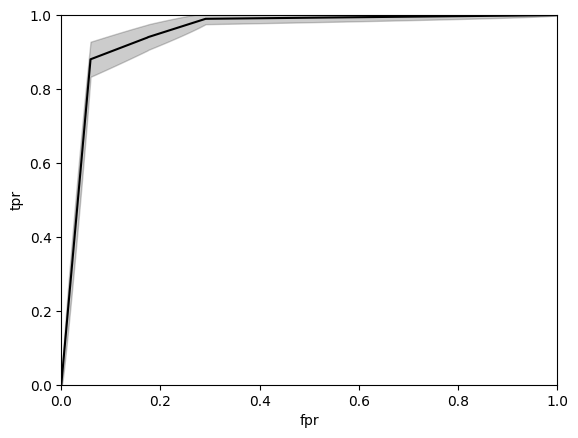

In [19]:
ax=plt.gca()
ax=ztm.get().tpr.plot(ax=ax,color='k')
plt.fill_between(x=ztm.get().index, y1=ztm.df_lim['U'].tpr,y2=ztm.df_lim['L'].tpr, color='k',alpha=.2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('tpr');

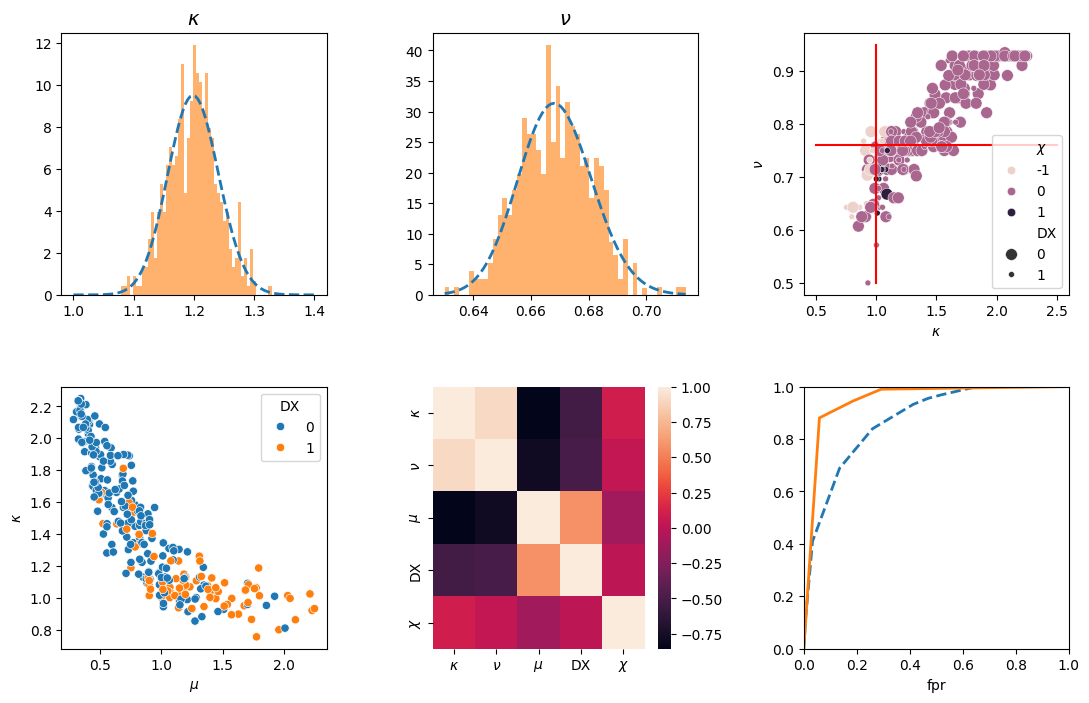

In [20]:
#from jupyterthemes import jtplot
#jtplot.style()


#plt.style.use('seaborn-talk')

plt.figure(figsize=[13,8])
plt.subplots_adjust(wspace=0.4, hspace=0.35)

# First subplot
plt.subplot(231)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, ld.pdf(x), '--',lw=2)
plt.hist(lf, bins=50, density=True, alpha=0.6)
#plt.xlabel('X-axis label', fontsize=12)  # Set font size for x-label
#plt.ylabel('Y-axis label', fontsize=12)  # Set font size for y-label
plt.title('$\kappa$', fontsize=14)    # Set font size for title

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Second subplot
plt.subplot(232)
xd = np.linspace(xmind, xmaxd, 100)
plt.plot(xd, vd.pdf(xd), '--',lw=2)
plt.hist(vf, bins=50, density=True, alpha=0.6)
plt.title(r"$\nu$", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

# First subplot
plt.subplot(233)
C0=1
C1=0.76
C2=1.25
#ax=sns.scatterplot(data=response_dataframe,x='score',y='veritas',hue='dx')
#plt.plot([.2,2.5],[C1,C1],'-r')
#plt.plot([C2,C2],[.5,.95],'-r')
sns.scatterplot(data=wf2,x=r'$\kappa$',y=r'$\nu$',hue=r'$\chi$',size='DX')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);



# First subplot
plt.subplot(234)
sns.scatterplot(data=wf2,x=r'$\mu$',y=r'$\kappa$',hue='DX')
#plt.plot([.2,2.5],[C0,C0],'-r')
#plt.plot([C2,C2],[.5,2],'-r')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);


# First subplot
plt.subplot(235)
sns.heatmap(wf2.corr())


# First subplot
plt.subplot(236)
zt.get().tpr.plot(lw=2,style='--')
ztm.get().tpr.plot(lw=2)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

plt.savefig('fig2.pdf',dpi=600,bbox_inches='tight',transparent=True)

ImportError: cannot import name 'utils' from 'quasinet.qnet' (/home/ishanu/.pyenv/versions/3.9.18/lib/python3.9/site-packages/quasinet/qnet.py)